In [11]:
#!pip install h5py
#!pip install torch torchvision torchaudio
#!pip install scikit-image

In [1]:
import h5py
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import random
import pandas as pd

In [2]:
parent_dir = '/Users/victor/code/afallo/brain_tumor_detection_project/raw_data/Brain Tumor Dataset'

In [3]:
def load_brain_tumor_dataset_h5py(parent_folder):
    """
    Parcourt tous les sous-dossiers, charge tous les fichiers .mat (v7.3 supporté)
    en utilisant h5py, et les stocke dans une liste.
    """

    dataset = []
    count_loaded = 0
    total_files = 0

    # Compter tous les fichiers .mat pour le suivi
    for root, dirs, files in os.walk(parent_folder):
        total_files += len([f for f in files if f.endswith('.mat')])

    print(f"📦 Démarrage du chargement des {total_files} fichiers répartis dans les sous-dossiers (via h5py)...")

    # Parcourir les sous-dossiers et charger
    for root, dirs, files in os.walk(parent_folder):
        mat_files = [f for f in files if f.endswith('.mat')]

        # Ignorer le fichier cvind.mat
        mat_files = [f for f in mat_files if f != 'cvind.mat']

        if mat_files:
            print(f"\n   -> Chargement des fichiers dans : {os.path.basename(root)}...")

            for i, file_name in enumerate(mat_files):
                file_path = os.path.join(root, file_name)

                try:
                    # --- NOUVEAU CHARGEMENT AVEC H5PY ---
                    with h5py.File(file_path, 'r') as f:
                        # La structure de données est maintenant accessible comme un dictionnaire HDF5
                        # L'élément 'cjdata' est la clé principale
                        cjdata = f['cjdata']

                        # Les données stockées sont transposées et souvent encodées.
                        # On utilise .value, .transpose() et np.array pour obtenir la forme correcte.

                        # 1. Image Data (Souvent transposée dans h5py)
                        # np.array() est utilisé pour convertir le Dataset HDF5 en Array NumPy
                        # .transpose() est nécessaire pour retrouver la forme 512x512
                        image_data = np.array(cjdata['image']).transpose()

                        # 2. Masque de Tumeur
                        tumor_mask = np.array(cjdata['tumorMask']).transpose()

                        # 3. Label et PID (Ils sont stockés différemment, nécessitent d'être "déréférencés"
                        # et souvent lus en tant que flotteurs, puis convertis en int/str)
                        label = np.array(cjdata['label'])[0, 0]
                        pid_ref = cjdata['PID'][0, 0]
                        # PID est une référence complexe, nous allons l'ignorer pour l'instant
                        # et utiliser le nom du fichier comme identifiant unique si nécessaire.
                        # Si le PID est un entier simple, on le lit directement, sinon on utilise la méthode d'encodage.
                        # Pour ce dataset, le label est le plus important.

                        # Si le label est lu comme un float, on le convertit en int
                        label = int(label)

                        # Utiliser le nom du fichier comme un identifiant simple si le PID est trop complexe à extraire.
                        pid = file_name.split('.')[0]

                    # Stocker les données
                    sample = {
                        'filename': file_name,
                        'label': label,
                        'PID': pid,
                        'image': image_data,
                        'tumorMask': tumor_mask
                    }

                    dataset.append(sample)
                    count_loaded += 1

                except Exception as e:
                    print(f"⚠️ Erreur H5PY lors du traitement du fichier {file_name} : {e}")
                    # Le code continue au fichier suivant en cas d'erreur

    print(f"\n🎉 Chargement terminé. Total de {count_loaded} images chargées.")
    return dataset

In [4]:
brain_data = load_brain_tumor_dataset_h5py(parent_dir)

📦 Démarrage du chargement des 3065 fichiers répartis dans les sous-dossiers (via h5py)...

   -> Chargement des fichiers dans : brainTumorDataPublic_767-1532...

   -> Chargement des fichiers dans : brainTumorDataPublic_1-766...

   -> Chargement des fichiers dans : brainTumorDataPublic_2299-3064...

   -> Chargement des fichiers dans : brainTumorDataPublic_1533-2298...

🎉 Chargement terminé. Total de 3064 images chargées.



--- Analyse de la Distribution des Classes ---

🔢 Répartition par Type de Tumeur :
  - Méningiome (Label 1): 708 tranches (23.11%)
  - Gliome (Label 2): 1426 tranches (46.54%)
  - Hypophysaire (Label 3): 930 tranches (30.35%)

--- Visualisation d'un Échantillon Aléatoire ---


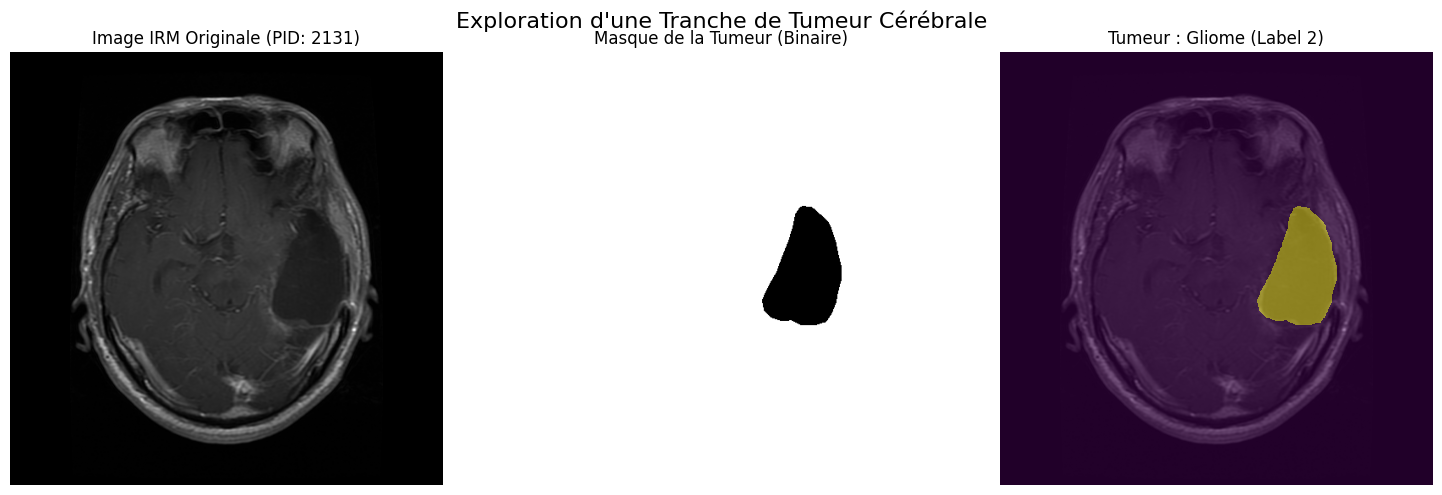

In [5]:
if brain_data:
    print("\n--- Analyse de la Distribution des Classes ---")

    # Extraire toutes les étiquettes (labels)
    labels = [sample['label'] for sample in brain_data]
    label_counts = Counter(labels)
    tumor_names = {1: 'Méningiome', 2: 'Gliome', 3: 'Hypophysaire'}

    print("\n🔢 Répartition par Type de Tumeur :")
    for label, count in sorted(label_counts.items()):
        name = tumor_names.get(label, 'Inconnu')
        print(f"  - {name} (Label {label}): {count} tranches ({count/len(brain_data)*100:.2f}%)")

    # [Le code de visualisation de la distribution (plt.bar) peut être réinséré ici]

    # --- 3. Visualisation d'un Échantillon Aléatoire ---
    if brain_data:
        print("\n--- Visualisation d'un Échantillon Aléatoire ---")
        random_sample = random.choice(brain_data)

        label = random_sample['label']
        name = tumor_names.get(label, 'Inconnu')
        image_data = random_sample['image']
        tumor_mask = random_sample['tumorMask']

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Affichage (le code de visualisation est le même qu'avant)
        axes[0].imshow(image_data, cmap='gray')
        axes[0].set_title(f"Image IRM Originale (PID: {random_sample['PID']})")
        axes[0].axis('off')

        axes[1].imshow(tumor_mask, cmap='binary')
        axes[1].set_title("Masque de la Tumeur (Binaire)")
        axes[1].axis('off')

        axes[2].imshow(image_data, cmap='gray')
        axes[2].imshow(tumor_mask, cmap='viridis', alpha=0.5, interpolation='none')
        axes[2].set_title(f"Tumeur : {name} (Label {label})")
        axes[2].axis('off')

        plt.suptitle(f"Exploration d'une Tranche de Tumeur Cérébrale", fontsize=16)
        plt.tight_layout()
        plt.show()

In [6]:
def load_brain_tumor_to_dataframe(parent_dir):
    """
    Parcourt tous les sous-dossiers, charge tous les fichiers .mat (v7.3 supporté)
    en utilisant h5py, et retourne un DataFrame Pandas contenant les métadonnées et les arrays.

    Args:
        parent_dir (str): Le chemin d'accès au dossier parent 'Brain Tumor Dataset'.

    Returns:
        pd.DataFrame: Un DataFrame contenant les colonnes 'filename', 'label', 'PID',
                      'image', et 'tumorMask'.
    """

    dataset_records = []
    count_loaded = 0
    total_files = 0

    # Compter tous les fichiers .mat pour le suivi
    for root, dirs, files in os.walk(parent_dir):
        total_files += len([f for f in files if f.endswith('.mat')])

    print(f"📦 Démarrage du chargement des {total_files} fichiers pour la création du DataFrame...")

    # Parcourir les sous-dossiers et charger
    for root, dirs, files in os.walk(parent_dir):
        mat_files = [f for f in files if f.endswith('.mat')]

        # Ignorer le fichier cvind.mat
        mat_files = [f for f in mat_files if f != 'cvind.mat']

        if mat_files:
            print(f"\n   -> Chargement des fichiers dans : {os.path.basename(root)}...")

            for i, file_name in enumerate(mat_files):
                file_path = os.path.join(root, file_name)

                try:
                    # NOUVEAU CHARGEMENT AVEC H5PY
                    with h5py.File(file_path, 'r') as f:
                        cjdata = f['cjdata']

                        # Extraction des données et transposition (.transpose() est crucial)
                        image_data = np.array(cjdata['image']).transpose()
                        tumor_mask = np.array(cjdata['tumorMask']).transpose()

                        # Extraction du Label
                        label = int(np.array(cjdata['label'])[0, 0])

                        # Utiliser le nom du fichier comme ID de la tranche
                        pid = file_name.split('.')[0]

                    # Stocker les données dans un dictionnaire (une ligne du futur DataFrame)
                    sample = {
                        'filename': file_name,
                        'label': label,
                        'PID': pid,
                        'image': image_data, # Stocker l'array NumPy complet
                        'tumorMask': tumor_mask # Stocker l'array NumPy complet
                    }

                    dataset_records.append(sample)
                    count_loaded += 1

                except Exception as e:
                    print(f"⚠️ Erreur H5PY lors du traitement du fichier {file_name} : {e}")

    print(f"\n🎉 Chargement terminé. Total de {count_loaded} images chargées.")

    # --- Créer le DataFrame Pandas ---
    df = pd.DataFrame(dataset_records)
    return df

In [7]:
# 1. Chargement et création du DataFrame
brain_df = load_brain_tumor_to_dataframe(parent_dir)

# --- Affichage d'un aperçu du DataFrame ---
if not brain_df.empty:
    print("\n--- Aperçu du DataFrame Créé ---")
    print(f"Taille du DataFrame : {brain_df.shape}")

    # Afficher les 5 premières lignes
    print(brain_df.head())

    print("\nTypes de données des colonnes :")
    print(brain_df.dtypes)

    # Vérification du contenu (optionnel)
    random_row = brain_df.sample(1).iloc[0]
    print(f"\nExemple de données image pour {random_row['filename']} :")
    print(f"  Shape de l'image: {random_row['image'].shape}")
    print(f"  Type de données de l'image: {random_row['image'].dtype}")

📦 Démarrage du chargement des 3065 fichiers pour la création du DataFrame...

   -> Chargement des fichiers dans : brainTumorDataPublic_767-1532...

   -> Chargement des fichiers dans : brainTumorDataPublic_1-766...

   -> Chargement des fichiers dans : brainTumorDataPublic_2299-3064...

   -> Chargement des fichiers dans : brainTumorDataPublic_1533-2298...

🎉 Chargement terminé. Total de 3064 images chargées.

--- Aperçu du DataFrame Créé ---
Taille du DataFrame : (3064, 5)
   filename  label   PID                                              image  \
0  1097.mat      3  1097  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  1083.mat      3  1083  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  1068.mat      3  1068  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  1054.mat      3  1054  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  1040.mat      3  1040  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                           tu

In [12]:
len(brain_df['image'])

3064

In [ ]:
OUTPUT_DIR = 'data/processed'  # Créez un dossier pour les données traitées
OUTPUT_FILENAME = 'brain_tumor_df_processed.pkl'
OUTPUT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

# Créer le dossier s'il n'existe pas
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Exportation au format Pickle
try:
    # ⚠️ Assurez-vous que 'brain_df' est bien le nom de votre DataFrame
    brain_df.to_pickle(OUTPUT_PATH)

    print(f"🎉 DataFrame exporté avec succès sous : {OUTPUT_PATH}")
    print("Ce fichier est prêt à être ajouté à Git.")

except Exception as e:
    print(f"❌ Erreur lors de l'exportation : {e}")

🎉 DataFrame exporté avec succès sous : data/processed/brain_tumor_df_processed.pkl
Ce fichier est prêt à être ajouté à Git.
